In [48]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [49]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# Normalize the input data to the range [0, 1], since there are 255 pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flatten the input data (from 28x28 images to 784 feature vectors) and transpose
X_train = X_train.reshape(X_train.shape[0], -1).T  # Shape: (784, num_examples)
X_test = X_test.reshape(X_test.shape[0], -1).T

In [50]:
#OPTIONAL -Display Number

def display_live_number(X, index):
    # plt.clf()  # Clear the current plot
    image = X[:, index].reshape(28, 28)  # Reshape the flattened image back to 28x28
    
    # Display the image
    plt.imshow(image, cmap="gray")
    plt.axis("off")

In [51]:
# Function to convert labels to one-hot encoding

def one_hot_encode(Y, num_classes):
    Y = Y.reshape(1, Y.shape[0])  # Reshape to (1, num_examples)
    Y_one_hot = np.zeros((num_classes, Y.shape[1]))  # Initialize a zero matrix with shape (num_classes, num_examples)
    Y_one_hot[Y.astype(int), np.arange(Y.shape[1])] = 1  # Set the appropriate indices to 1 for each class label
    return Y_one_hot





In [52]:
#function that initilizes the weights, will only need for training

def initialize_parameters(input_size, hidden_size, output_size):
    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2./input_size)  # shape: (hidden_size, input_size)
    b1 = np.zeros((hidden_size, 1))  # shape: (hidden_size, 1)
    W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2./hidden_size)  # shape: (hidden_size, hidden_size)
    b2 = np.zeros((hidden_size, 1))  # shape: (hidden_size, 1)
    W3 = np.random.randn(output_size, hidden_size) * np.sqrt(2./hidden_size)  # shape: (output_size, hidden_size)
    b3 = np.zeros((output_size, 1))  # shape: (output_size, 1)

    return W1, b1, W2, b2, W3, b3


In [53]:
#relu call to change data from linear representation to a more complex version so the deep learning process is more intricate

def relu(Z):
    return np.maximum(0, Z)

In [54]:
#for the last layer and for the output, the softmax will convert Z into probabilities based on the formula

def softmax(Z):
    # to highlight the more confident probabilities and to make positive probabilities:
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # For numerical stability
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [55]:
#forward pass algorithm

def forward_pass(X, W1, b1, W2, b2, W3, b3):
    # First hidden layer (Input -> Hidden Layer 1)
    Z1 = np.dot(W1, X) + b1  # Z1 shape: (hidden_size, num_examples)
    A1 = relu(Z1)

    # Second hidden layer (Hidden Layer 1 -> Hidden Layer 2)
    Z2 = np.dot(W2, A1) + b2  # Z2 shape: (hidden_size, num_examples)
    A2 = relu(Z2)
    
    # Output layer (Hidden Layer 2 -> Output)
    Z3 = np.dot(W3, A2) + b3  # Z3 shape: (output_size, num_examples)
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3  # Return the output probabilities and intermediate values

In [56]:
#loss calculation that finds the loss and how well the predicted values align with the true values

def compute_loss(A3, Y):
    m = Y.shape[1]  # Number of examples
    epsilon = 1e-15  # Small constant to avoid log(0)
    
    # Compute the log likelihood for the correct class (one-hot encoded labels)
    log_probs = np.multiply(np.log(A3 + epsilon), Y)  # Element-wise multiplication
    cost = -np.sum(log_probs) / m  # Average loss over the batch
    
    print("Accuracy: {}".format(np.mean(np.argmax(A3,axis=0) == np.argmax(Y,axis=0))*100))
    return cost

In [57]:
#derivative function that returns 0 if the Z is less than 0
def relu_derivative(Z):
    return Z > 0

In [58]:
#Backpropagation, going backwards in the neural network and calculating the slope and direction to move it to adjust based on the loss
#Backpropagation only finds the direction (slope) of the movement, not by actually finding how much it needs to move, that's the learning rate.

def backpropagation(X, Y, parameters, cache):
    m = X.shape[1]  # Number of examples (batch size)

    # cache is a type of memory retreival, where we are accessing the values of the following:
    A1 = cache['A1']  # relu version of weighted matrix layer 1
    A2 = cache['A2']  # relu version of weighted matrix layer 2
    A3 = cache['A3']  # softmax version of weighted matrix layer 3 (output layer)
    Z1 = cache['Z1']  # weighted matrix pre-relu layer 1
    Z2 = cache['Z2']  # weighted matrix pre-relu layer 2

    W1, W2, W3 = parameters['W1'], parameters['W2'], parameters['W3']

    # Layer 3: Compute the gradient for layer 3, output layer
    dZ3 = A3 - Y

    # Layer 3: Compute the gradients for W3 and b3 (output layer)
    dW3 = np.dot(dZ3, A2.T) / m  # Gradient of W3
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m  # Gradient of b3

    # Layer 2: Backpropagate the error to the second hidden layer (Z2)
    dZ2 = np.dot(W3.T, dZ3) * relu_derivative(Z2)  # Gradient of Z2

    # Layer 2: Compute the gradients for W2 and b2 (second hidden layer)
    dW2 = np.dot(dZ2, A1.T) / m  # Gradient of W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m  # Gradient of b2

    # Layer 1: Backpropagate the error to the first hidden layer (Z1)
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)  # Gradient of Z1
    
    # Layer 1: Compute the gradients for W1 and b1 (first hidden layer)
    dW1 = np.dot(dZ1, X.T) / m  # Gradient of W1
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m  # Gradient of b1

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

    return gradients

In [59]:
#This is the actual gradient descent step where the weights and biases are updated based on a learning rate (usually beginning at 0.01)
#The gradient descent step will repeat multiple times, each time adjusting the weight and bias closer and closer for precision

def gradient_descent(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate):
    # Update weights and biases using gradient descent
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    
    return W1, b1, W2, b2, W3, b3

In [60]:
#training the algorithm
def train(X, Y, input_size, hidden_layer_size, output_size, num_iterations, learning_rate, batch_size=128):
    # Initialize the parameters (weights and biases)
    W1, b1, W2, b2, W3, b3 = initialize_parameters(input_size, hidden_layer_size, output_size)
    m = X.shape[1]
    costs = []
    
    # Train for the specified number of iterations
    for iteration in range(num_iterations):
        # Mini-batch implementation
        for batch_start in range(0, m, batch_size):
            batch_end = min(batch_start + batch_size, m)
            X_batch = X[:, batch_start:batch_end]
            Y_batch = Y[:, batch_start:batch_end]
            
            # Forward propagation
            Z1, A1, Z2, A2, Z3, A3 = forward_pass(X_batch, W1, b1, W2, b2, W3, b3)
            
            # Compute loss for monitoring
            if batch_start == 0 and (iteration+1) % 1 == 0:
                cost = compute_loss(A3, Y_batch)
                costs.append(cost)
                print(f"Iteration {iteration+1}, Cost: {cost}")
            
            # Backpropagation to compute gradients
            gradients = backpropagation(X_batch, Y_batch, 
                                      {"W1": W1, "W2": W2, "W3": W3},
                                      {'A1': A1, 'A2': A2, 'A3': A3, 'Z1': Z1, 'Z2': Z2})
            
            # Update parameters using gradient descent
            W1, b1, W2, b2, W3, b3 = gradient_descent(
                W1, b1, W2, b2, W3, b3,
                gradients['dW1'], gradients['db1'],
                gradients['dW2'], gradients['db2'],
                gradients['dW3'], gradients['db3'],
                learning_rate
            )
    
    return W1, b1, W2, b2, W3, b3, costs

In [61]:
#Main Class to train and run

input_size = 784  # each image is 28x28 pixels
hidden_layer_size = 128  # number of neurons in each hidden layer (increased from 20 for better performance)
output_size = 10  # 0-9 possible values
num_iterations = 10  # running the training 10 times to modify the matrices accordingly
learning_rate = 0.1
batch_size = 128

# Prepare data with one-hot encoding
Y_train = one_hot_encode(Y_train, output_size)
Y_test = one_hot_encode(Y_test, output_size)

# Train the model
W1, b1, W2, b2, W3, b3, costs = train(X_train, Y_train, input_size, hidden_layer_size, output_size, num_iterations, learning_rate, batch_size)

Accuracy: 10.9375
Iteration 1, Cost: 2.329885037184076
Accuracy: 96.875
Iteration 2, Cost: 0.1559679900338018
Accuracy: 97.65625
Iteration 3, Cost: 0.10401677301939699
Accuracy: 97.65625
Iteration 4, Cost: 0.08172242023886588
Accuracy: 98.4375
Iteration 5, Cost: 0.06844367084368308
Accuracy: 98.4375
Iteration 6, Cost: 0.05905333505115837
Accuracy: 99.21875
Iteration 7, Cost: 0.04905936391301063
Accuracy: 99.21875
Iteration 8, Cost: 0.04163234415167916
Accuracy: 99.21875
Iteration 9, Cost: 0.03642851970775748
Accuracy: 99.21875
Iteration 10, Cost: 0.03297071303401823


Accuracy: 97.39

Actual: 6 Predicted: 5

Actual: 4 Predicted: 2

Actual: 6 Predicted: 0

Actual: 8 Predicted: 4

Actual: 2 Predicted: 7

Actual: 6 Predicted: 0

Actual: 3 Predicted: 5

Actual: 8 Predicted: 0

Actual: 8 Predicted: 2

Actual: 4 Predicted: 6

Actual: 3 Predicted: 9

Actual: 2 Predicted: 6

Actual: 2 Predicted: 1

Actual: 7 Predicted: 3

Actual: 7 Predicted: 9

Actual: 8 Predicted: 4

Actual: 9 Predicted: 4

Actual: 8 Predicted: 5

Actual: 8 Predicted: 9

Actual: 5 Predicted: 4

Actual: 6 Predicted: 0

Actual: 6 Predicted: 5

Actual: 7 Predicted: 2

Actual: 6 Predicted: 8

Actual: 4 Predicted: 6

Actual: 7 Predicted: 8

Actual: 3 Predicted: 5

Actual: 6 Predicted: 1

Actual: 6 Predicted: 5

Actual: 7 Predicted: 9

Actual: 2 Predicted: 4

Actual: 7 Predicted: 2

Actual: 9 Predicted: 4

Actual: 4 Predicted: 9

Actual: 9 Predicted: 0

Actual: 7 Predicted: 1

Actual: 8 Predicted: 3

Actual: 7 Predicted: 9

Actual: 8 Predicted: 3

Actual: 3 Predicted: 5

Actual: 7 Predicted: 0


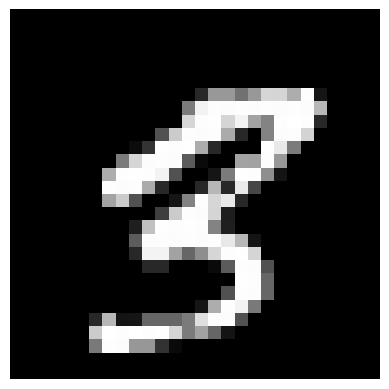

In [62]:
Z1, A1, Z2, A2, Z3, A3 = forward_pass(X_test, W1, b1, W2, b2, W3, b3)

print("Accuracy: {}".format(np.mean(np.argmax(A3,axis=0) == np.argmax(Y_test,axis=0))*100))

for i,x in enumerate(range(A3.shape[1])):
    maxpred=np.argmax(A3[:,x])
    maxac=np.argmax(Y_test[:,x])

    if (maxpred!=maxac):
        display_live_number(X_test, i)
        # print("\nActual: {}".format(maxac,end=""),end="")
        # print(" Predicted: {}".format(maxpred))